In [443]:
import pdb
import pandas as pd
import numpy as np
import os
import random
from scipy import stats
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from faker import Faker
np.random.seed(3101)
random_state = np.random.RandomState(3101)
fake = Faker()
pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))

# Importing data:
bank1 = archive  
bank2 = bank+marketing

In [444]:
# print(os.getcwd())
bank_df_train = pd.read_csv('./data/main/train.csv')
bank_df_test = pd.read_csv('./data/main/test.csv')

In [445]:
print(bank_df_train.head())
print(len(bank_df_train))

# bank_df_train_clean = bank_df_train.drop_duplicates(subset="CustomerId", keep="first")
# print(len(bank_df_train_clean))

   id  CustomerId         Surname  CreditScore Geography Gender       Age  \
0   0    15674932  Okwudilichukwu          668    France   Male 33.000000   
1   1    15749177   Okwudiliolisa          627    France   Male 33.000000   
2   2    15694510           Hsueh          678    France   Male 40.000000   
3   3    15741417             Kao          581    France   Male 34.000000   
4   4    15766172       Chiemenam          716     Spain   Male 33.000000   

   Tenure       Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       3      0.000000              2   1.000000        0.000000   
1       1      0.000000              2   1.000000        1.000000   
2      10      0.000000              2   1.000000        0.000000   
3       2 148882.540000              1   1.000000        1.000000   
4       5      0.000000              2   1.000000        1.000000   

   EstimatedSalary  Exited  
0    181449.970000       0  
1     49503.500000       0  
2    184866.690000       0  
3     

In [446]:
print(bank_df_test.head())
len(bank_df_test)
# duplicates = bank_df_test.duplicated(subset=['CustomerId'], keep=False)
# print(duplicates)
#no "exited" column

       id  CustomerId    Surname  CreditScore Geography  Gender       Age  \
0  165034    15773898   Lucchese          586    France  Female 23.000000   
1  165035    15782418       Nott          683    France  Female 46.000000   
2  165036    15807120         K?          656    France  Female 34.000000   
3  165037    15808905  O'Donnell          681    France    Male 36.000000   
4  165038    15607314    Higgins          752   Germany    Male 38.000000   

   Tenure       Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2      0.000000              2   0.000000        1.000000   
1       2      0.000000              1   1.000000        0.000000   
2       7      0.000000              2   1.000000        0.000000   
3       8      0.000000              1   1.000000        0.000000   
4      10 121263.620000              1   1.000000        0.000000   

   EstimatedSalary  
0    160976.750000  
1     72549.270000  
2    138882.090000  
3    113931.570000  
4    139431.00000

110023

Data Cleaning

Removed CustomerId column in both test & train since it is an unused var in the original dataset
All other columns returns no duplicates

In [447]:
# bank_df_train = bank_df_train.loc[:, bank_df_train.columns!='CustomerId'] # extract all columns except for CustomerId
# print(bank_df_train[bank_df_train.duplicated() == True]) # check for duplicate columns 

# bank_df_test = bank_df_test.loc[:, bank_df_test.columns!='CustomerId']

### DELETE OR COMMENT OUT THIS LATER ###
bank_df_train.drop_duplicates(subset=['CustomerId'], inplace=True)
bank_df_test.drop_duplicates(subset=['CustomerId'], inplace=True)
n_train = len(bank_df_train)
print(n_train)
### DELETE OR COMMENT OUT THIS LATER ###

# n_test = len(bank_df_test)

23221


# Adding and populating features

### 13. Churn Date: The exact date the customer decided to exit.

In [448]:
start_date = "2023-01-01"
end_date = end_date = datetime.now().strftime('%Y-%m-%d') 

# random_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# random_dates_str = random_dates.strftime('%Y-%m-%d')
# bank_df_train['ChurnDate'] = np.where(bank_df_train['Exited'] == 1, np.random.choice(random_dates_str) , np.nan) 
def generate_random_date(exited):
    if exited == 1:
        random_date = np.random.choice(pd.date_range(start=start_date, end=end_date, freq='D'))
        return random_date
    else:
        return None

bank_df_train['ChurnDate'] = bank_df_train['Exited'].apply(generate_random_date)
bank_df_train['ChurnDate'] = pd.to_datetime(bank_df_train['ChurnDate'])
print(bank_df_train['ChurnDate'].head(10))
# print(bank_df_train['ChurnDate'].unique())

0          NaT
1          NaT
2          NaT
3          NaT
4          NaT
5   2023-07-20
6          NaT
7          NaT
8          NaT
9          NaT
Name: ChurnDate, dtype: datetime64[ns]


### 14. Sign Up Date: When did the customer create an account
has to be linked with churn date if any, and tenure. Tenure is usually rounded down, so (not needed anymore)


In [449]:
# def generate_signon_date(churn_date, tenure, exited):
#     if exited == 0:
#         churn_date = datetime.now().strftime('%Y-%m-%d')
#     churn_date = pd.to_datetime(churn_date)
#     max = churn_date - pd.DateOffset(years=tenure)
#     min = churn_date - pd.DateOffset(years=(tenure + 1))
#     random_dates = pd.date_range(min, max, freq='D').strftime('%Y-%m-%d')
#     random_date = np.random.choice(random_dates)
#     return random_date


# bank_df_train['SignDate'] = bank_df_train.apply(lambda row: generate_signon_date(row['ChurnDate'], row['Tenure'], row['Exited']), axis = 1)
# print(bank_df_train[['SignDate', 'ChurnDate', 'Tenure']].head(10))

# bank_df_test['SignDate'] = bank_df_train.apply(lambda row: generate_signon_date("2023-12-31", row['Tenure'], 0), axis = 1)
# # print(bank_df_train_clean.head(10))
# bank_df_train['SignDate'] = pd.to_datetime(bank_df_train['SignDate'])

### 15.Transaction History 1
Detailed transaction data offers insights into spending patterns and engagement. (Transaction frequency in the last 28 days)

In [450]:
transaction_df = pd.read_excel('./data/transaction_history.xlsx')

# print(transaction_df.head())
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'])

grouped_df = transaction_df.groupby('Account No')

results = []
for group_name, group_data in grouped_df:
    # Get max and min dates for the group
    max_date = group_data['DATE'].max()
    min_date = max_date - pd.Timedelta(days=28)
    
    # Filter group data for transactions within the date range
    filtered_group = group_data[(group_data['DATE'] >= min_date) & (group_data['DATE'] <= max_date)]
    
    # Calculate transaction frequency and amount for the group
    transaction_frequency = len(filtered_group)
    transaction_amount = filtered_group['DEPOSIT AMT'].sum()
    
    # Append results to the list
    results.append({
        'Account No': group_name,
        'Total Transaction Amount': transaction_amount,
        'Transaction Frequency': transaction_frequency
    })

# Create DataFrame from results
result_df = pd.DataFrame(results)

result_df['Total Transaction Amount'] = result_df['Total Transaction Amount'].astype(int)
pd.options.display.float_format = '{:,.0f}'.format
# print(result_df['Total Transaction Amount'])

# print("Minimum date in the dataset:", min_date)
# print("Maximum date in the dataset:", max_date)

kde_freq = gaussian_kde(result_df['Transaction Frequency'])
kde_amnt = gaussian_kde(result_df['Total Transaction Amount'])
# print(result_df['Total Transaction Amount'])

fake_data_freq = kde_freq.resample(len(bank_df_train)).flatten()
fake_data_freq = np.round(fake_data_freq).astype(int)
bank_df_train['TransactionFreq'] = fake_data_freq
fake_data_freq = kde_freq.resample(len(bank_df_test)).flatten()
fake_data_freq = np.round(fake_data_freq).astype(int)
bank_df_test['TransactionFreq'] = fake_data_freq

# fake_data_amt = kde_amnt.resample(len(bank_df_train)).flatten()
# # fake_data_amt = np.round(fake_data_amt).astype(int)
# bank_df_train['TransactionAmnt'] = fake_data_amt
# fake_data_amt = kde_amnt.resample(len(bank_df_test)).flatten()
# # fake_data_amt = np.round(fake_data_amt).astype(int)
# bank_df_test['TransactionAmnt'] = fake_data_amt

# print(bank_df_train['TransactionAmnt'].head())
date_28_days_ago = datetime.now() - timedelta(days=28)

bank_df_train['TransactionFreq'] = np.where(
    (bank_df_train['ChurnDate'] <= date_28_days_ago),
    0,
    bank_df_train['TransactionFreq']
)

bank_df_train['TransactionFreq'] = np.maximum(bank_df_train['TransactionFreq'], 0)

print(bank_df_train[['ChurnDate', 'TransactionFreq']].head(20))

    ChurnDate  TransactionFreq
0         NaT              347
1         NaT              498
2         NaT                0
3         NaT              161
4         NaT              414
5  2023-07-20                0
6         NaT                0
7         NaT                0
8         NaT                0
9         NaT                0
10        NaT               70
11        NaT                0
12        NaT              178
13        NaT              207
14        NaT               97
15        NaT              137
16        NaT              488
17        NaT                0
18 2023-03-10                0
19 2023-12-18                0


### 16. Transaction History 2
Detailed transaction data offers insights into spending patterns and engagement. (Transaction amount in the last 28 days)


In [451]:
# Import reference set
# Warning: File size slightly big
trans_hist_data = pd.read_excel('./data/transaction_history.xlsx')

trans_hist_data.dtypes
# trans_hist_data.describe()

# Extract the most recent 2 sets of 3 months assuming the most recent data is the most accurate
trans_1st_3mths = trans_hist_data[(trans_hist_data['DATE'] >= pd.to_datetime('2019-01')) & (trans_hist_data['DATE'] <= pd.to_datetime('2019-03'))]
trans_2ns_3mths = trans_hist_data[(trans_hist_data['DATE'] >= pd.to_datetime('2018-10')) & (trans_hist_data['DATE'] <= pd.to_datetime('2018-12'))]

trans_dist_data = trans_1st_3mths.groupby('Account No').agg({'VALUE DATE': 'size', 'WITHDRAWAL AMT':'sum', 'DEPOSIT AMT': 'sum'}).reset_index()
trans_dist_data['TOTAL AMT'] = -trans_dist_data['WITHDRAWAL AMT'] + trans_dist_data['DEPOSIT AMT']

# kde = gaussian_kde(trans_dist_data['VALUE DATE'])
# train['Transaction Freq'] = abs(kde.resample(n_train).flatten()).astype(int)

kde = gaussian_kde(trans_dist_data['TOTAL AMT'])
bank_df_train['Transaction Amt'] = kde.resample(n_train).flatten().astype(float)

date_28_days_ago = datetime.now() - timedelta(days=28)

bank_df_train['Transaction Amt'] = np.where(
    (bank_df_train['ChurnDate'] <= date_28_days_ago),
    0,
    bank_df_train['Transaction Amt']
)

bank_df_train['Transaction Amt'] = np.where(
    (bank_df_train['TransactionFreq'] == 0),
    0,
    bank_df_train['Transaction Amt']
)

# bank_df_train['Transaction Amt'] = np.maximum(bank_df_train['Transaction Amt'], 0)

print(bank_df_train[['ChurnDate', 'TransactionFreq', 'Transaction Amt']].head(20))

    ChurnDate  TransactionFreq  Transaction Amt
0         NaT              347          175,182
1         NaT              498       -1,951,719
2         NaT                0                0
3         NaT              161        1,198,124
4         NaT              414        3,630,592
5  2023-07-20                0                0
6         NaT                0                0
7         NaT                0                0
8         NaT                0                0
9         NaT                0                0
10        NaT               70          189,576
11        NaT                0                0
12        NaT              178       -1,727,603
13        NaT              207      -10,790,420
14        NaT               97       -4,438,810
15        NaT              137       -6,132,123
16        NaT              488       -1,406,833
17        NaT                0                0
18 2023-03-10                0                0
19 2023-12-18                0          

### 17.Service Support Frequency (per mth)

In [452]:

support_freq = pd.read_csv("./data/support_frequency.csv")
kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['ServiceSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)

print(bank_df_train['ServiceSupportFrequency'])


0         17
1          2
2          0
3          5
4         11
          ..
164879    11
164931    21
164961    18
164998    11
165012    29
Name: ServiceSupportFrequency, Length: 23221, dtype: int32


### 18.Months Inactive
Indicates customer disengagement, potentially preceding churn. 

In [453]:
np.random.seed(3101)
# bank_df_train['MonthsInactive'] = np.minimum(np.random.normal(0.5, 1.5, n_train), bank_df_train['Tenure'] * 12)
# bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)
# bank_df_train['MonthsInactive'] = bank_df_train['TransactionFreq'].apply(lambda x: 0 if x > 0 else  \
#                                                                               np.maximum(np.minimum(np.random.normal(0.5, 1.5, n_train), bank_df_train['Tenure'] * 12), 0))
bank_df_train['MonthsInactive'] = bank_df_train.apply(lambda row: 
    np.random.normal(0.5, 1.5) if row['TransactionFreq'] == 0 else 0,
    axis=1)

print(bank_df_train['MonthsInactive'].head(20))

0    0
1    0
2    1
3    0
4    0
5    1
6    2
7    0
8    1
9    2
10   0
11   3
12   0
13   0
14   0
15   0
16   0
17   1
18   1
19   0
Name: MonthsInactive, dtype: float64


### 19.Net Promoter Score (NPS)
Measure of customer satisfaction and loyalty.
Scaled from 1 to 10 


In [454]:
nps = pd.read_csv('./data/NPS.csv')

nps_data = nps.groupby('Customer Name').agg({'NPS':'mean'}).reset_index()
kde = gaussian_kde(nps_data['NPS'])
bank_df_train['NPS'] = abs(kde.resample(n_train).flatten()).astype(int)

print(bank_df_train['NPS'])

0          0
1          8
2         10
3          0
4          7
          ..
164879     7
164931     0
164961     5
164998    10
165012    10
Name: NPS, Length: 23221, dtype: int32


### 20.Education
Education level might influence financial behavior and churn.
Shld be correlated to 5. Acct Balance


In [455]:
education_marital = pd.read_csv("./data/education_marital.csv")

education = education_marital['Education_Level'].unique()

edu, counts = np.unique(education, return_counts=True)
value_to_index = {value: i for i, value in enumerate(edu)}
numerical_data = [value_to_index[value] for value in education]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [edu[index] for index in resampled_indices]

bank_df_train['Education'] = resampled_values

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  IsActiveMember  EstimatedSalary  Exited  \
0        0              2  ...               0          181,450       0   
1        0              2  ...               1           49,504       0   
2        0              2  ...               0          184,867       0   
3  148,883              1  ...               1           84,561       0   
4        0              2  ...               1           15,069       0   

   ChurnDate TransactionFreq  Transaction Amt  ServiceSupportFrequen

### 21.Employment Status
Indicates financial stability, affecting churn likelihood. 
Shld be correlated to 5. Acct Balance & 21. Education  

In [456]:
employment = pd.read_csv("./data/employment.csv")

employment_data = employment['job'].unique()

employment_status, counts = np.unique(employment_data, return_counts=True)
value_to_index = {value: i for i, value in enumerate(employment_status)}
numerical_data = [value_to_index[value] for value in employment_data]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)
pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [employment_status[index] for index in resampled_indices]

bank_df_train['Employment Status'] = resampled_values

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  EstimatedSalary  Exited  ChurnDate  \
0        0              2  ...          181,450       0        NaT   
1        0              2  ...           49,504       0        NaT   
2        0              2  ...          184,867       0        NaT   
3  148,883              1  ...           84,561       0        NaT   
4        0              2  ...           15,069       0        NaT   

   TransactionFreq Transaction Amt  ServiceSupportFrequency  MonthsInactive  \
0              347 

### 22.Marital Status
Can impact financial decision-making and churn behavior. 

In [457]:
education_marital = pd.read_csv("./data/education_marital.csv")

marital_status = education_marital['Marital_Status'].unique()

marital, counts = np.unique(marital_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(marital)}
numerical_data = [value_to_index[value] for value in marital_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [marital[index] for index in resampled_indices]

bank_df_train['Marital Status'] = resampled_values

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  Exited  ChurnDate  TransactionFreq  \
0        0              2  ...       0        NaT              347   
1        0              2  ...       0        NaT              498   
2        0              2  ...       0        NaT                0   
3  148,883              1  ...       0        NaT              161   
4        0              2  ...       0        NaT              414   

   Transaction Amt ServiceSupportFrequency  MonthsInactive  NPS  \
0          175,182             

### 23.Housing Status
Reflects stability and long-term commitment, influencing churn. 

In [458]:
housing = pd.read_csv("./data/housing.csv")

housing_status = housing['House_Ownership'].unique()

house, counts = np.unique(housing_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(house)}
numerical_data = [value_to_index[value] for value in housing_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [house[index] for index in resampled_indices]

bank_df_train['Housing Status'] = resampled_values

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  ChurnDate  TransactionFreq  Transaction Amt  \
0        0              2  ...        NaT              347          175,182   
1        0              2  ...        NaT              498       -1,951,719   
2        0              2  ...        NaT                0                0   
3  148,883              1  ...        NaT              161        1,198,124   
4        0              2  ...        NaT              414        3,630,592   

   ServiceSupportFrequency MonthsInactive  N

### 24.Number of Dependents
Impacts financial priorities and risk tolerance, affecting churn.

In [459]:
dependants_df = pd.read_csv('./data/education+dependents+maritalstatus/BankChurners.csv')

kde = gaussian_kde(dependants_df['Dependent_count'])

bank_df_train['Dependants'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_train['Dependants'] = np.round(bank_df_train['Dependants']).astype(int)
bank_df_test['Dependants'] = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
bank_df_test['Dependants'] = np.round(bank_df_test['Dependants']).astype(int)

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  TransactionFreq  Transaction Amt  \
0        0              2  ...              347          175,182   
1        0              2  ...              498       -1,951,719   
2        0              2  ...                0                0   
3  148,883              1  ...              161        1,198,124   
4        0              2  ...              414        3,630,592   

   ServiceSupportFrequency  MonthsInactive NPS      Education  \
0                       17               0   

### 25.Marketing Offers Accepted
Indicates responsiveness to incentives, affecting churn. Range 0-1, (percentage of marketing offers they accept, e.g.5 offer, 4 accepted, the value of the column 0.8)

In [460]:
marketing_df = pd.read_csv('./data/marketing offers/marketing_campaign.csv', sep=';')


marketing_df["MarketingOffersAcceptance"] = (marketing_df['AcceptedCmp1'] + marketing_df['AcceptedCmp2'] + marketing_df['AcceptedCmp3'] + marketing_df['AcceptedCmp4'] + marketing_df['AcceptedCmp5']) / 5
# print(marketing_df.head())

kde = gaussian_kde(marketing_df['MarketingOffersAcceptance'])

bank_df_train['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_test['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  Transaction Amt  ServiceSupportFrequency  \
0        0              2  ...          175,182                       17   
1        0              2  ...       -1,951,719                        2   
2        0              2  ...                0                        0   
3  148,883              1  ...        1,198,124                        5   
4        0              2  ...        3,630,592                       11   

   MonthsInactive  NPS      Education  Employment Status  Mari

### 26.Channel Used for Transactions
Reflects preferred banking channels and engagement level. 
faker

In [461]:
transaction_channel_df = pd.read_csv('./data/main_payment_method/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# print(transaction_channel_df.head())
methods = transaction_channel_df['PaymentMethod'].unique().tolist()
print(methods)
faked_data = [random.choice(methods) for _ in range(len(bank_df_train))]
faked_data_2 = [random.choice(methods) for _ in range(len(bank_df_test))]

bank_df_train['PaymentMethod'] = faked_data
bank_df_test['PaymentMethod'] = faked_data_2
print(bank_df_train.head())

['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  ServiceSupportFrequency  MonthsInactive  NPS  \
0        0              2  ...                       17               0    0   
1        0              2  ...                        2               0    8   
2        0              2  ...                        0               1   10   
3  148,883              1  ...                        5               0    0   
4        0              2 

### 27.Customer Satisfaction Surveys
Provides direct feedback on satisfaction levels, predicting churn. 

In [462]:
cust_satisfaction_df = pd.read_csv('./data/satisfaction score/Customer-Churn-Records.csv')

kde = gaussian_kde(cust_satisfaction_df['Satisfaction Score'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 5)
fake_data = np.round(fake_data).astype(int)

fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 5)
fake_data_2 = np.round(fake_data_2).astype(int)

bank_df_train['CustomerSatisfaction'] = fake_data
bank_df_test['CustomerSatisfaction'] = fake_data_2
# print(len(bank_df_test))
# print(len(fake_data_2))

print(bank_df_train['CustomerSatisfaction'].head(10))

0    5
1    3
2    5
3    4
4    2
5    5
6    4
7    1
8    3
9    5
Name: CustomerSatisfaction, dtype: int32


### 28.Feature Satisfaction
Scale on 1 to 5


In [463]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with your overall delivery experience at Ali?                    1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['FeatureSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_test['FeatureSatisfaction'] = kde.resample(len(bank_df_test)).flatten().astype(int)

print(bank_df_train['FeatureSatisfaction'].head())

0    5
1    4
2    2
3    1
4    1
Name: FeatureSatisfaction, dtype: int32


### 29.Support Satisfaction
Scale on 1 to 5


In [464]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with the speed of delivery at Alis?                                1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['SupportSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_test['SupportSatisfaction'] = kde.resample(len(bank_df_test)).flatten().astype(int)

print(bank_df_train['SupportSatisfaction'].head())

0    4
1    5
2    4
3    2
4    0
Name: SupportSatisfaction, dtype: int32


### 30. Feature support frequency

Higher calls might indicate issues and dissatisfaction, affecting churn. Past year. Past month 


In [465]:
support_freq = pd.read_csv("./data/support_frequency.csv")

kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['FeatureSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)
print(bank_df_train.head())


   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  Employment Status  Marital Status  \
0        0              2  ...             admin.          Single   
1        0              2  ...      self-employed        Divorced   
2        0              2  ...            student         Unknown   
3  148,883              1  ...            unknown          Single   
4        0              2  ...          housemaid        Divorced   

   Housing Status  Dependants MarketingOffersAcceptance  \
0          rented           1                

### 31.Relationship Count
Reflects the breadth of the customer's relationship with the bank.
Shld be correlated to 6: No. of products   

In [466]:
relationship_count = pd.read_csv('./data/loan/credit_train.csv')
relationship_count['Current Loan Amount'].fillna(0, inplace=True) 

if np.any(np.isinf(relationship_count['Current Loan Amount'])):
    # Handle infinite values, such as replacing them with a large finite value
    relationship_count['Current Loan Amount'].replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)


median_loan_amount = relationship_count['Current Loan Amount'].median()
below_median = relationship_count[relationship_count['Current Loan Amount'] < median_loan_amount]
above_median = relationship_count[relationship_count['Current Loan Amount'] >= median_loan_amount]

# print(above_median)
kde_upper = gaussian_kde(above_median['Current Loan Amount'])
kde_lower = gaussian_kde(below_median['Current Loan Amount'])

bank_df_train['RelationshipCount'] = np.where(bank_df_train['CustomerSatisfaction'] >= 4, abs(kde_upper.resample(n_train).flatten()/12).astype(int) , abs(kde_lower.resample(n_train).flatten()/12).astype(int))


# kde = gaussian_kde(relationship_count['Current Loan Amount'])
# bank_df_train['RelationshipCount'] = abs(kde.resample(n_train).flatten()/12).astype(int)

print(bank_df_train['RelationshipCount'].head())
print(bank_df_train['RelationshipCount'].max())
print(bank_df_train['RelationshipCount'].min())

0    552052
1     13832
2     44210
3    188766
4     11730
Name: RelationshipCount, dtype: int32
9616106
5


### 32. Income Source
Indicates financial stability and potential churn risk. 

In [467]:
income_source_df = pd.read_csv('./data/income source/adult.csv')

# print(transaction_channel_df.head())
income_sourcs = income_source_df['workclass'].unique().tolist()
income_sourcs.remove('?')
print(income_sourcs)
faked_data = [random.choice(income_sourcs) for _ in range(len(bank_df_train))]
faked_data_2 = [random.choice(income_sourcs) for _ in range(len(bank_df_test))]

bank_df_train['IncomeSource'] = faked_data
bank_df_test['IncomeSource'] = faked_data_2
print(bank_df_train.head())

['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']
   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  Housing Status  Dependants  \
0        0              2  ...          rented           1   
1        0              2  ...           owned           3   
2        0              2  ...    norent_noown           3   
3  148,883              1  ...           owned           1   
4        0              2  ...           owned           3   

   MarketingOffersAcceptan

### 33. Credit Utilization
Reflects financial health and potential churn risk for credit customers.

In [468]:
credit_df = pd.read_csv('./data/credit utilization/BankChurners.csv')

kde = gaussian_kde(credit_df['Avg_Utilization_Ratio'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 1)
# fake_data = np.round(fake_data).astype(int)
fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 1)

bank_df_train['CreditUtilization'] = fake_data
bank_df_test['CreditUtilization'] = fake_data_2

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  Dependants  MarketingOffersAcceptance  \
0        0              2  ...           1                          0   
1        0              2  ...           3                          0   
2        0              2  ...           3                          0   
3  148,883              1  ...           1                          0   
4        0              2  ...           3                          0   

               PaymentMethod  CustomerSatisfaction FeatureSatisfaction  \
0  Ban

### 34. Response to Previous Retention Efforts
Records success or failure of previous retention efforts, guiding future strategies. % 0-1

In [469]:
retention_df = pd.read_csv('./data/retention/HR_comma_sep.csv')

kde = gaussian_kde(retention_df['promotion_last_5years'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 1)

fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 1)


bank_df_train['Retention'] = fake_data
bank_df_test['Retention'] = fake_data_2

print(bank_df_train['Retention'].head(20))

0    0
1    0
2    1
3    0
4    0
5    0
6    0
7    0
8    0
9    0
10   0
11   0
12   0
13   0
14   0
15   0
16   0
17   0
18   0
19   0
Name: Retention, dtype: float64


### 35. Change in behavior before n after
Average of percentage of increase/decrease (ranging from 0 - infinity, but most of the times it will be ard 0-2)

In [470]:
bank_df_train['ChangeInBehaviourMkt'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_test['ChangeInBehaviourMkt']= np.random.normal(1, 0.25, len(bank_df_test))
# test = np.random.normal(1, 0.25, len(bank_df_train))
# # print(test)
# bank_df_train['ChangeInBehaviourMkt'] = test.astype(float)

print(bank_df_train['ChangeInBehaviourMkt'].head(10))

0   1
1   1
2   1
3   1
4   1
5   1
6   1
7   1
8   1
9   1
Name: ChangeInBehaviourMkt, dtype: float64


### 36. Change in behavior before n after for Support

In [471]:
bank_df_train['ChanegInBehaviourCust'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_test['ChanegInBehaviourCust']= np.random.normal(1, 0.25, len(bank_df_test))

print(bank_df_train['ChanegInBehaviourCust'].head())

0   1
1   1
2   1
3   1
4   1
Name: ChanegInBehaviourCust, dtype: float64


### 37. Previous Lifecycle status 

In [472]:
life_cycles = ['Active', 'Dormant', 'Reactivated'] #everything but churned

bank_df_train['PrevLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['Exited'] == 1 else np.random.choice(life_cycles), axis=1)

print(bank_df_train['PrevLifecycle'].head(10))

0    Reactivated
1        Dormant
2    Reactivated
3         Active
4        Dormant
5        Churned
6    Reactivated
7        Dormant
8         Active
9        Dormant
Name: PrevLifecycle, dtype: object


### 38. Current Lifecycle status 

In [473]:
prev_active = ['Active', 'Dormant'] #excluding churn, also same for reactivated
prev_dormant = ['Dormant', 'Reactivated'] #excluding churn

# bank_df_train['CurrLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['PrevLifecycle'] == 'Churned' else \
#                                                     np.random.choice(prev_active) if (row['PrevLifecycle'] == 'Active' or row['PrevLifecycle'] == 'Reactivated') else \
#                                                     np.random.choice(prev_dormant) if row['PrevLifecycle'] == 'Dormant' else \
#                                                     np.nan, axis=1)
bank_df_train['CurrLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['PrevLifecycle'] == 'Churned' else \
                                                     'Reactivated' if (row['PrevLifecycle'] == 'Dormant' and row['TransactionFreq'] > 0) else \
                                                     'Dormant' if row['TransactionFreq'] == 0 else \
                                                     'active', axis=1)

print(bank_df_train[['PrevLifecycle', 'CurrLifecycle']].head(10))


  PrevLifecycle CurrLifecycle
0   Reactivated        active
1       Dormant   Reactivated
2   Reactivated       Dormant
3        Active        active
4       Dormant   Reactivated
5       Churned       Churned
6   Reactivated       Dormant
7       Dormant       Dormant
8        Active       Dormant
9       Dormant       Dormant


### 39. Customer Happiness Status 
1 == happy, 0 == unhappy

Customer satisfaction survey score 

Relationship Count 

Response to previous retention efforts (no more yay)

if we want the top 15.9%


In [474]:
happiness_benchmark = 84.1

# bank_df_train['Happiness'] = bank_df_train.apply(lambda row: 1 if row['CustomerSatisfaction'] + \
#                                                                   row['FeatureSatisfaction'] + \
#                                                                   row['SupportSatisfaction'] + \
#                                                                   row['NPS'] + \
#                                                                   row['Tenure'] >= happiness_benchmark else \
#                                                                   0, axis=1)


# need to delete Custpercentile, RsPercentile and ResponsePercentile later
bank_df_train['CustPercentile'] = bank_df_train['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))
bank_df_train['RsPercentile'] = bank_df_train['RelationshipCount'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))

# print(bank_df_train['CustPercentile'].head(10))
bank_df_train['Happiness'] = bank_df_train.apply(lambda row: 1 if (row['CustPercentile'] > happiness_benchmark and \
                                                                   row['RsPercentile'] > happiness_benchmark ) else 0, axis=1)
bank_df_train.drop(columns=['CustPercentile', 'RsPercentile'], inplace=True)

print(bank_df_train['Happiness'].head(10))
print("percentage happy =", (bank_df_train['Happiness'] == 1).mean() * 100)

0    1
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    0
9    1
Name: Happiness, dtype: int64
percentage happy = 19.783816373110547


### 40.Price Sensitivity %
26. marketing offers accepted %
35. change in behaviour %

Mkting Offers Accepted
Change in behavior before n after for mkting offer 


In [475]:
MarketingOffersAcceptance_df = bank_df_train['MarketingOffersAcceptance'].apply(lambda x: stats.percentileofscore(bank_df_train['MarketingOffersAcceptance'], x))
ChangeInBehaviourMkt_df = bank_df_train['ChangeInBehaviourMkt'].apply(lambda x: stats.percentileofscore(bank_df_train['ChangeInBehaviourMkt'], x))
# print(MarketingOffersAcceptance_df.head())
# print(ChangeInBehaviourMkt_df.head())
bank_df_train['PriceSensitivity'] = (MarketingOffersAcceptance_df + ChangeInBehaviourMkt_df) / 2

print(bank_df_train['PriceSensitivity'].head(20))

0    48
1    34
2    45
3    53
4    44
5    48
6    65
7    77
8    30
9    55
10   74
11   70
12   72
13   59
14   52
15   63
16   58
17   43
18   22
19   74
Name: PriceSensitivity, dtype: float64


### 41.Feature Driven % 
28. Customer satisfaction survey 0-5
6. num products 1-4
29. Feature Satisfaction 0-5

Number of products last 1 year
Feature Satisfaction Column (0 to 1)
Feature Support freq


In [476]:
# print(bank_df_train['NumOfProducts'].max())
# print(bank_df_train['NumOfProducts'].min())

# feature_driven = bank_df_train['CustomerSatisfaction'] + bank_df_train['NumOfProducts'] + bank_df_train['FeatureSatisfaction']
# percentiles = np.percentile(feature_driven, [0, 25, 50, 75, 100]) 

# def assign_percentile(metric):
#     if metric <= percentiles[1]:
#         return ((metric / percentiles[1]) * 25)
#     elif metric <= percentiles[2]:
#         return (25 + ((metric - percentiles[1]) / (percentiles[2] - percentiles[1])) * 25)
#     elif metric <= percentiles[3]:
#         return (50 + ((metric - percentiles[2]) / (percentiles[3] - percentiles[2])) * 25)
#     else:
#         return (75 + ((metric - percentiles[3]) / (percentiles[4] - percentiles[3])) * 25)
        
# bank_df_train['FeatureSensitivity'] = feature_driven.apply(assign_percentile)
# bank_df_train['FeatureSensitivity'] = bank_df_train['FeatureSensitivity'].replace(np.NaN, 0, regex=True)

CustomerSatisfaction_df = bank_df_train['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))
NumOfProducts_df = bank_df_train['NumOfProducts'].apply(lambda x: stats.percentileofscore(bank_df_train['NumOfProducts'], x))
FeatureSatisfaction_df = bank_df_train['FeatureSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['FeatureSatisfaction'], x))
FeatureSupportFrequency_df = bank_df_train['FeatureSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['FeatureSatisfaction'], x))

bank_df_train['FeatureSensitivity'] = (CustomerSatisfaction_df + NumOfProducts_df + FeatureSatisfaction_df + FeatureSupportFrequency_df) / 4

print(bank_df_train['FeatureSensitivity'].head(20))

0    89
1    52
2    74
3    52
4    54
5    76
6    62
7    30
8    52
9    72
10   47
11   20
12   57
13   32
14   49
15   28
16   64
17   59
18   47
19   47
Name: FeatureSensitivity, dtype: float64


### 42.Service Driven % 
31. service support freq per month number
39. Customer Happiness Status binary
36. Change in behavior before n after for Support %

CALL Support frequency
Support Satisfaction Column (0 to 1)
Change in behavior before n after support

In [477]:
# print(bank_df_train['ServiceSupportFrequency'])
# CallSupportFrequency_df = bank_df_train['CallSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['CallSupportFrequency'], x))
ServiceSupportFrequency_df = bank_df_train['ServiceSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['ServiceSupportFrequency'], x))
SupportSatisfaction_df = bank_df_train['SupportSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['SupportSatisfaction'], x))
ChanegInBehaviourCust_df = bank_df_train['ChanegInBehaviourCust'].apply(lambda x: stats.percentileofscore(bank_df_train['ChanegInBehaviourCust'], x))

bank_df_train['ServiceSensitivity'] = (ServiceSupportFrequency_df + SupportSatisfaction_df + ChanegInBehaviourCust_df) / 3

print(bank_df_train['ServiceSensitivity'].head())

0   52
1   42
2   46
3   25
4   37
Name: ServiceSensitivity, dtype: float64


### 43.Customer Personas 

In [478]:
columns_to_normalize = ['PriceSensitivity', 'FeatureSensitivity', 'ServiceSensitivity']

bank_df_train[columns_to_normalize] = bank_df_train[columns_to_normalize].div(bank_df_train[columns_to_normalize].sum(axis=1), axis=0) * 100
bank_df_train['CustomerPersona'] = bank_df_train[columns_to_normalize].idxmax(axis=1)

print(bank_df_train[['PriceSensitivity', 'FeatureSensitivity', 'ServiceSensitivity', 'CustomerPersona']])

        PriceSensitivity  FeatureSensitivity  ServiceSensitivity  \
0                     25                  47                  27   
1                     27                  41                  33   
2                     27                  45                  28   
3                     41                  40                  19   
4                     32                  40                  27   
...                  ...                 ...                 ...   
164879                32                  30                  37   
164931                23                  37                  40   
164961                24                  45                  32   
164998                26                  42                  32   
165012                25                  45                  30   

           CustomerPersona  
0       FeatureSensitivity  
1       FeatureSensitivity  
2       FeatureSensitivity  
3         PriceSensitivity  
4       FeatureSensitivity  
...      

### 44. Social Influencer

In [479]:
social_benchmark = 84.1

bank_df_train['SocialInfluencer'] = bank_df_train['NPS'].apply(lambda x: stats.percentileofscore(bank_df_train['NPS'], x))
bank_df_train['SocialInfluencer'] = bank_df_train.apply(lambda row: 1 if (row['SocialInfluencer'] > happiness_benchmark) else 0, axis=1)

print(bank_df_train['SocialInfluencer'].head(10))
print("percentage social influencer =", (bank_df_train['SocialInfluencer'] == 1).mean() * 100)

0    0
1    0
2    1
3    0
4    0
5    0
6    0
7    1
8    0
9    0
Name: SocialInfluencer, dtype: int64
percentage social influencer = 16.640110245036823


# Removing useless columns and label encoding columns with string
Date columns will be converted to numerics to be able to train

In [480]:
# print(bank_df_train.dtypes)
useless_cols = ['id', 'CustomerId', 'Surname', 'Geography']
to_one_hot_encode_cols = ['Gender', 'Education', 'Employment Status', 'Marital Status', 'Housing Status', 'PaymentMethod', 'IncomeSource', 'PrevLifecycle', 'CurrLifecycle', 'CustomerPersona']

bank_df_train.drop(columns=useless_cols, inplace=True)
bank_df_train = pd.get_dummies(bank_df_train, columns=to_one_hot_encode_cols)



In [481]:
# reference_date = bank_df_train['ChurnDate'].min()
# bank_df_train['ChurnDate_Numeric'] = (bank_df_train['ChurnDate'] - reference_date).dt.days
# bank_df_train['ChurnDate_Numeric'] = pd.to_numeric(bank_df_train['ChurnDate'])


print(bank_df_train.dtypes)
print(bank_df_train.head(10))

# to get our dates back
# bank_df_train['ChurnDate_Back'] = reference_date + pd.to_timedelta(bank_df_train['ChurnDate_Numeric'], unit='D')

CreditScore                             int64
Age                                   float64
Tenure                                  int64
Balance                               float64
NumOfProducts                           int64
                                       ...   
CurrLifecycle_Reactivated                bool
CurrLifecycle_active                     bool
CustomerPersona_FeatureSensitivity       bool
CustomerPersona_PriceSensitivity         bool
CustomerPersona_ServiceSensitivity       bool
Length: 82, dtype: object
   CreditScore  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
0          668   33       3        0              2          1   
1          627   33       1        0              2          1   
2          678   40      10        0              2          1   
3          581   34       2  148,883              1          1   
4          716   33       5        0              2          1   
5          588   36       4  131,779              1          1   
6     

In [482]:
# print(reference_date + pd.to_timedelta(464, unit='D'))

# EDA


### 1. Correlation matrix

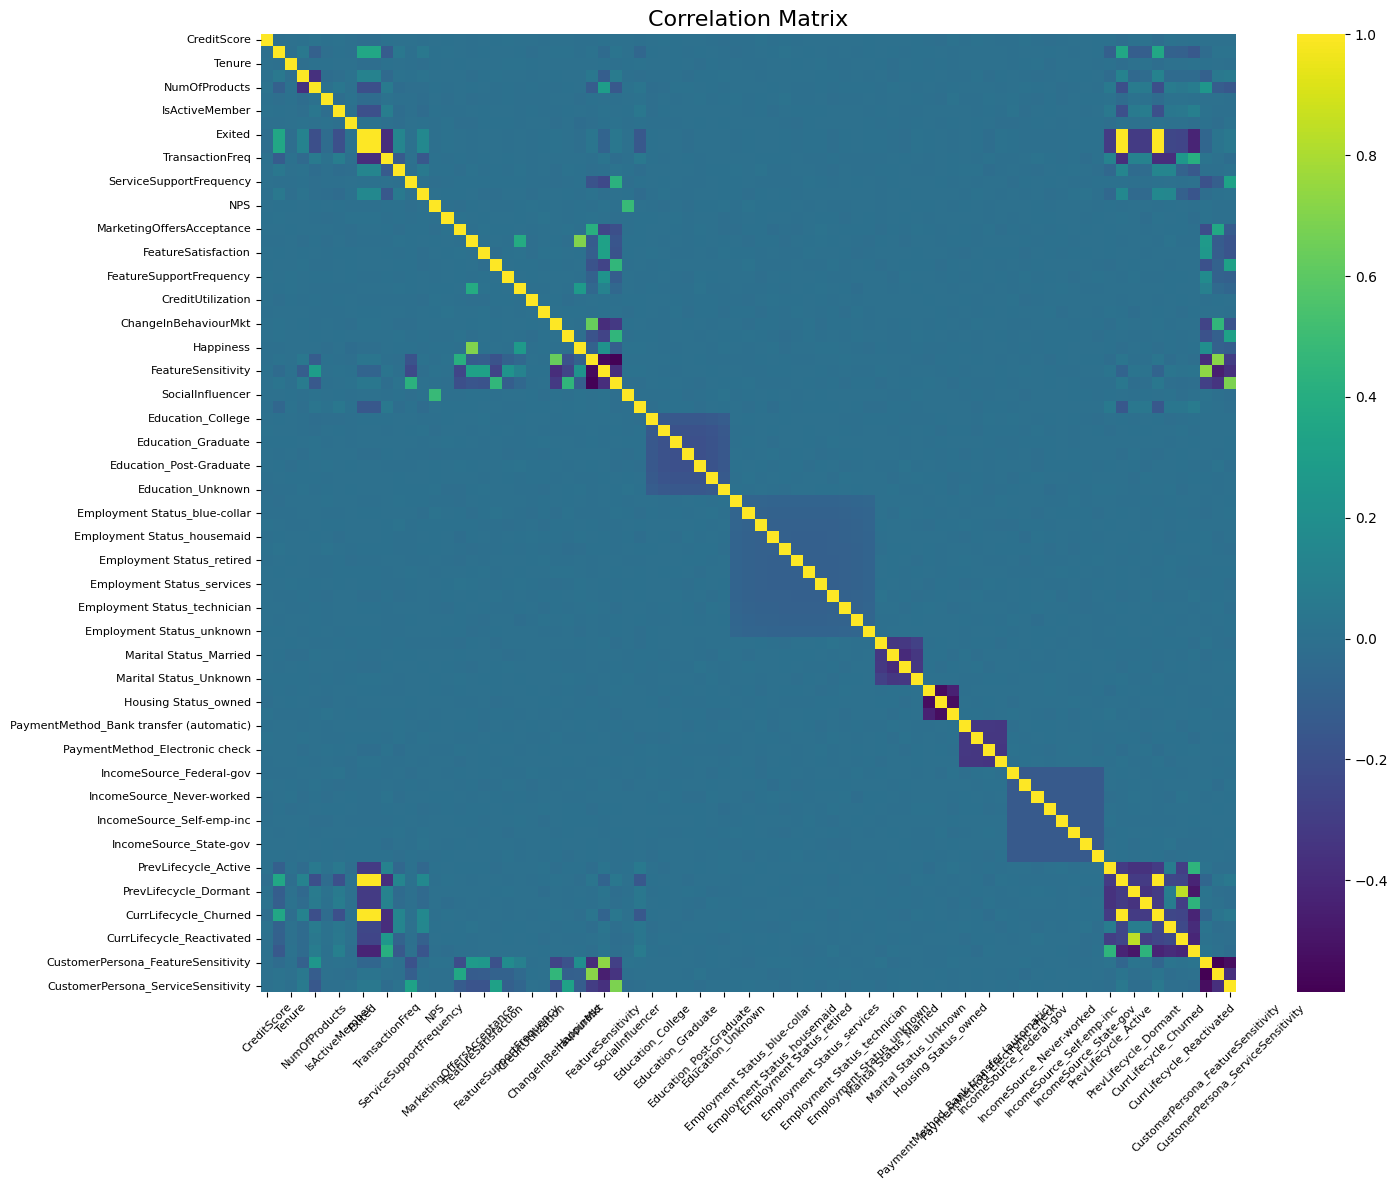

Exited and ChurnDate: 0.9999992772837885
Exited and PrevLifecycle_Churned: 1.0
Exited and CurrLifecycle_Churned: 1.0
ChurnDate and Exited: 0.9999992772837885
ChurnDate and PrevLifecycle_Churned: 0.9999992772837885
ChurnDate and CurrLifecycle_Churned: 0.9999992772837885
PrevLifecycle_Churned and Exited: 1.0
PrevLifecycle_Churned and ChurnDate: 0.9999992772837885
PrevLifecycle_Churned and CurrLifecycle_Churned: 1.0
PrevLifecycle_Dormant and CurrLifecycle_Reactivated: 0.8396010019536579
CurrLifecycle_Churned and Exited: 1.0
CurrLifecycle_Churned and ChurnDate: 0.9999992772837885
CurrLifecycle_Churned and PrevLifecycle_Churned: 1.0
CurrLifecycle_Reactivated and PrevLifecycle_Dormant: 0.8396010019536579


In [492]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix and covariance matrix
cov_matrix = bank_df_train.cov()
corr_matrix = bank_df_train.corr()

# Plot the heatmap for all columns without numeric annotations
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')

# Customize the plot
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Display the plot
plt.tight_layout()
plt.show()

# Identify highly correlated columns
correlated_columns = []
threshold = 0.75   # Adjust as needed

for col in corr_matrix.columns:
    correlated_cols = corr_matrix.index[(corr_matrix[col] > threshold) | (corr_matrix[col] < -threshold)].tolist()
    correlated_cols.remove(col)  # Remove the current column itself
    correlated_columns.extend([(col, corr) for corr in correlated_cols])

# Print highly correlated columns and their correlations
for col, corr in correlated_columns:
    print(f"{col} and {corr}: {corr_matrix.loc[col, corr]}")


In [484]:
useless_cols = ['Gender_Female']
bank_df_train.drop(columns=useless_cols, inplace=True)

### 2. LDA

In [485]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



### 3. Aprior

In [486]:
#code for apriori

### 4. Domain knowledge

In [487]:
#domain knowledge....

# Model training test
check if the data is fit for training

In [488]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

df = bank_df_train.copy()
# df['ChurnDate_Numeric'].fillna(0, inplace=True)

X = df.drop(columns=['Exited', 'ChurnDate'])
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00
